In [1]:
import numpy as np
import matplotlib.patches as mpatches
from matplotlib import pyplot as plt
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV

%matplotlib inline

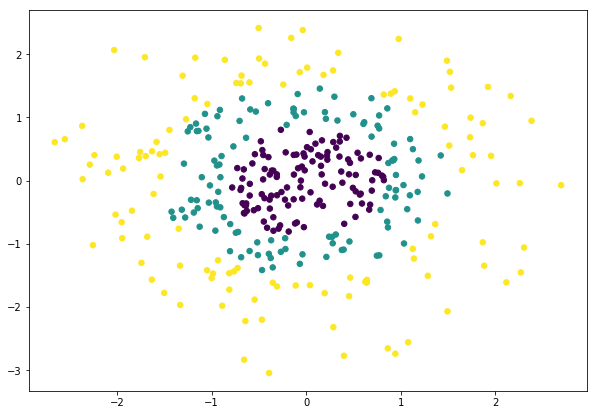

In [2]:
# Generate a dataset and plot it
np.random.seed(0)
X, y = make_gaussian_quantiles(n_features=2, n_classes=3, n_samples=350)
plt.figure(figsize=(10, 7))
plt.scatter(X[:,0], X[:,1], s=30, c=y)

In [3]:
def plot_decision_boundary(predict, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.007
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral_r)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral_r)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
del X, y

In [5]:
def my_tanh(array, backward=False):
    if backward:
        return (1 - np.power(array, 2))
    return np.tanh(array)

In [6]:
def my_sigmoid(array, backward=False):
    if backward:
        s = my_sigmoid(array)
        return s*(1 - s)
    return 1 / (1 + np.exp(-array))

In [7]:
def my_relu(array, hidden_values=None, backward=False):
    if backward and hidden_values is not None:
        array[hidden_values <= 0] = 0
        return array
    return np.maximum(0, array)

In [8]:
def my_softmax(array):
    ex = np.exp(array)
    return ex / np.sum(ex, axis=1, keepdims=True)

In [9]:
def forward_pass(model, X):
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    z1 = X.dot(W1) + b1
    a1 = my_relu(z1)
    z2 = a1.dot(W2) + b2
    a2 = my_relu(z2)
    z3 = a2.dot(W3) + b3
    return my_softmax(z3), a2, a1

In [10]:
def calc_loss(model, X, y, reg):
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    probs, a2, a1 = forward_pass(model, X)
    correct_logprobs = -np.log(probs[range(len(X)), y])
    data_loss = np.sum(correct_logprobs)
    reg_loss = reg / 2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3)))
    loss = data_loss + reg_loss
    return loss / len(X)

In [11]:
def predict(model, X):
    probs, a2, a1 = forward_pass(model, X)
    return np.argmax(probs, axis=1)

In [12]:
def show_legend():
    classes = ['AKA','P_AKA', 'KI', 'P_KI', 'AO', 'P_AO']
    sp = plt.cm.get_cmap('Spectral')
    d2 = plt.cm.get_cmap('binary_r')
    class_colours = [sp(0), d2(0), sp(127), d2(127), sp(255), d2(255)]
    recs = []
    for i in range(len(class_colours)):
        recs.append(mpatches.FancyArrow(0, 1, 1, 1,1,fc=class_colours[i]))
    return plt.legend(recs, classes, loc=1)

In [54]:
input_size = 2 # input layer dimensionality -> position in the plane
output_size = 3 # output layer dimensionality -> 3 gaussian quantiles

def make_model(X, y, epochs, hidden_size, decay=None, batch_size=None, print_loss=None, lr=0.02, reg=0.01):

    def get_mini_batch(X, y, n_train, batch_size):
        mask = np.random.choice(a=n_train, size=batch_size, replace=False)
        return X[mask], y[mask]
    
    def one_hot(k):
        vector = np.zeros(3, dtype=int)
        vector[k] = 1
        return vector

    y = np.asarray([one_hot(i) for i in y])
    
    if batch_size is not None:
        N = batch_size
    else:
        N = len(X) # training set size 
        
    model = {}
    # ReLU weights (recommended)
    model['W1'] = np.random.randn(input_size, hidden_size) * np.sqrt(2/N)
    model['W2'] = np.random.randn(hidden_size, hidden_size) * np.sqrt(2/N)
    model['W3'] = np.random.randn(hidden_size, output_size) * np.sqrt(2/N)
    
    model['b1'] = np.zeros((1, hidden_size))
    model['b2'] = np.zeros((1, hidden_size))
    model['b3'] = np.zeros((1, output_size))
    
    # Default weights
    #model['W1'] = 1e-4 * np.random.randn(input_size, hidden_size)
    #model['W2'] = 1e-4 * np.random.randn(hidden_size, hidden_size)
    #model['W3'] = 1e-4 * np.random.randn(hidden_size, output_size)
    
    for i in range(epochs):
        if batch_size is not None:
            X, y = get_mini_batch(X, y, N, batch_size)
    
        # Forward
        probs, a2, a1 = forward_pass(model, X)

        # Backward
        delta4 = probs - y
        dW3 = (a2.T).dot(delta4)
        db3 = np.sum(delta4, axis=0, keepdims=True)
        delta3 = delta4.dot(model['W3'].T) 
        delta3= my_relu(delta3, a2, backward=True)
        dW2 = np.dot(a1.T, delta3)
        db2 = np.sum(delta3, axis=0)
        delta2 = delta3.dot(model['W2'].T)
        delta2 = my_relu(delta2, a1, backward=True)
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Add regularization terms (weights only)
        dW3 += reg * model['W3']
        dW2 += reg * model['W2']
        dW1 += reg * model['W1']

        # LR decay
        if decay is not None:
            ratio, iterations = decay
            if i % iterations == 0:
                if 0 < ratio < 1:
                    lr -= lr * ratio
        
        # Gradient descent parameter update
        model['W1'] += -lr * dW1
        model['b1'] += -lr * db1
        model['W2'] += -lr * dW2
        model['b2'] += -lr * db2
        model['W3'] += -lr * dW3
        model['b3'] += -lr * db3

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss is not None and i % print_loss == 0:
          print("Loss after iteration %i: %f" %(i, calc_loss(model, X_train, y_train, reg=reg)))
    return model

In [55]:
model = make_model(X_train, y_train, lr=0.0001, print_loss=5000, epochs=20001, hidden_size=6)

Loss after iteration 0: 1.099212
Loss after iteration 5000: 0.084817
Loss after iteration 10000: 0.049716
Loss after iteration 15000: 0.040701
Loss after iteration 20000: 0.033960


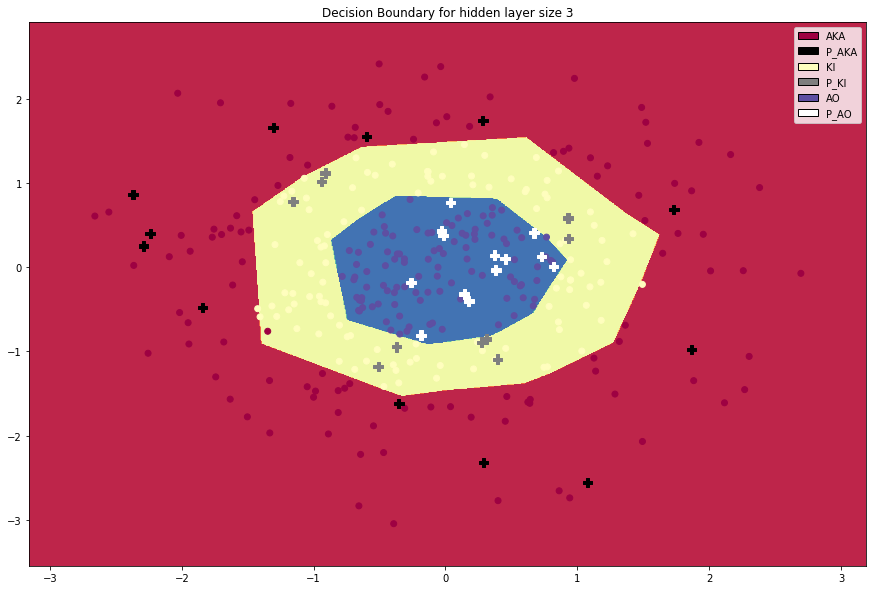

In [56]:
predictions = predict(model, X_test)
plt.figure(figsize=(15, 10))
plot_decision_boundary(lambda x: predict(model, x), X_train, y_train)
plt.scatter(X_test[:,0], X_test[:,1], s=90, c=predictions, cmap=plt.cm.binary, marker='P')
plt.title("Decision Boundary for hidden layer size 3")
show_legend()

Loss after iteration 0: 1.098378
Loss after iteration 5000: 0.016687
Loss after iteration 10000: 0.008369
Loss after iteration 15000: 0.006950
Loss after iteration 20000: 0.006521
Loss after iteration 25000: 0.006057
Loss after iteration 30000: 0.005844
Loss after iteration 35000: 0.005681
Loss after iteration 40000: 0.005576
Loss after iteration 45000: 0.005506
Loss after iteration 50000: 0.005451
Loss after iteration 55000: 0.005406
Loss after iteration 60000: 0.005370
Loss after iteration 65000: 0.005338
Loss after iteration 70000: 0.005311
Loss after iteration 75000: 0.005287
Loss after iteration 80000: 0.005268
Loss after iteration 85000: 0.005250
Loss after iteration 90000: 0.005235
Loss after iteration 95000: 0.005221
Loss after iteration 100000: 0.005209
Loss after iteration 0: 1.098427
Loss after iteration 5000: 0.021976
Loss after iteration 10000: 0.015163
Loss after iteration 15000: 0.085328
Loss after iteration 20000: 0.009567
Loss after iteration 25000: 0.008388
Loss after

/home/fd/Dev/wildml/.venv/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/home/fd/Dev/wildml/.venv/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


Loss after iteration 0: 1.097280
Loss after iteration 5000: 0.006281
Loss after iteration 10000: 0.005594
Loss after iteration 15000: 0.005443
Loss after iteration 20000: 0.005370
Loss after iteration 25000: 0.005311
Loss after iteration 30000: 0.005264
Loss after iteration 35000: 0.005231
Loss after iteration 40000: 0.005203
Loss after iteration 45000: 0.005180
Loss after iteration 50000: 0.005160
Loss after iteration 55000: 0.005142
Loss after iteration 60000: 0.005127
Loss after iteration 65000: 0.005113
Loss after iteration 70000: 0.005100
Loss after iteration 75000: 0.005088
Loss after iteration 80000: 0.005076
Loss after iteration 85000: 0.005065
Loss after iteration 90000: 0.005056
Loss after iteration 95000: 0.005049
Loss after iteration 100000: 0.005042
Loss after iteration 0: 1.099292
Loss after iteration 5000: 0.007802
Loss after iteration 10000: 0.005812
Loss after iteration 15000: 0.005569
Loss after iteration 20000: 0.005453
Loss after iteration 25000: 0.005368
Loss after

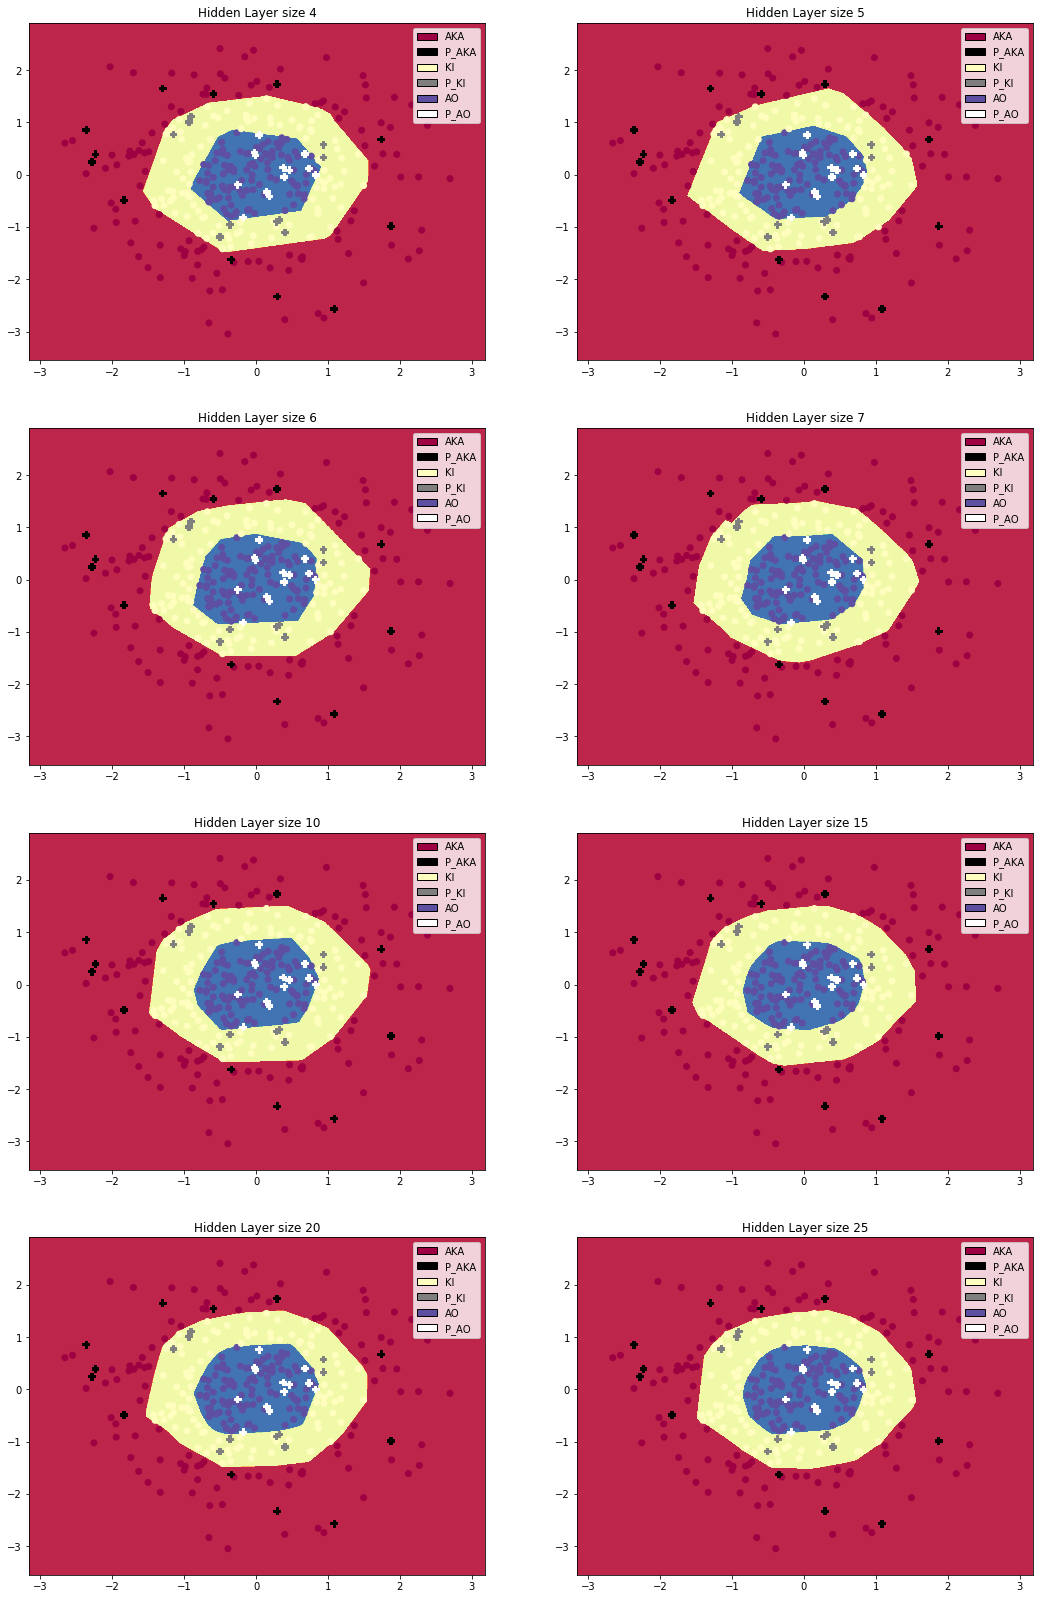

In [67]:
plt.figure(figsize=(18, 36))
hidden_sizes = [4, 5, 6, 7, 10, 15, 20, 25]

for i, hidden_size in enumerate(hidden_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % hidden_size)
    model = make_model(X_train, y_train, 100001, hidden_sizes[i], lr=0.002, print_loss=5000)
    predictions = predict(model, X_test)
    plot_decision_boundary(lambda x: predict(model, x), X_train, y_train)
    plt.scatter(X_test[:,0], X_test[:,1], s=45, c=predictions, cmap=plt.cm.binary, marker='P')
    show_legend()
plt.show()

Loss after iteration 0: 1.094552
Loss after iteration 5000: 0.004393
Loss after iteration 10000: 0.004107
Loss after iteration 15000: 0.004016
Loss after iteration 20000: 0.003959
Loss after iteration 25000: 0.003913
Loss after iteration 30000: 0.003874
Loss after iteration 35000: 0.003842
Loss after iteration 40000: 0.003815
Loss after iteration 45000: 0.003793
Loss after iteration 50000: 0.003774
Loss after iteration 0: 1.096700
Loss after iteration 5000: 0.004361
Loss after iteration 10000: 0.004111
Loss after iteration 15000: 0.004033
Loss after iteration 20000: 0.003985
Loss after iteration 25000: 0.003947
Loss after iteration 30000: 0.003915
Loss after iteration 35000: 0.003891
Loss after iteration 40000: 0.003872
Loss after iteration 45000: 0.003854
Loss after iteration 50000: 0.003840
Loss after iteration 0: 1.097759
Loss after iteration 5000: 0.004488
Loss after iteration 10000: 0.004222
Loss after iteration 15000: 0.004130
Loss after iteration 20000: 0.004063
Loss after itera

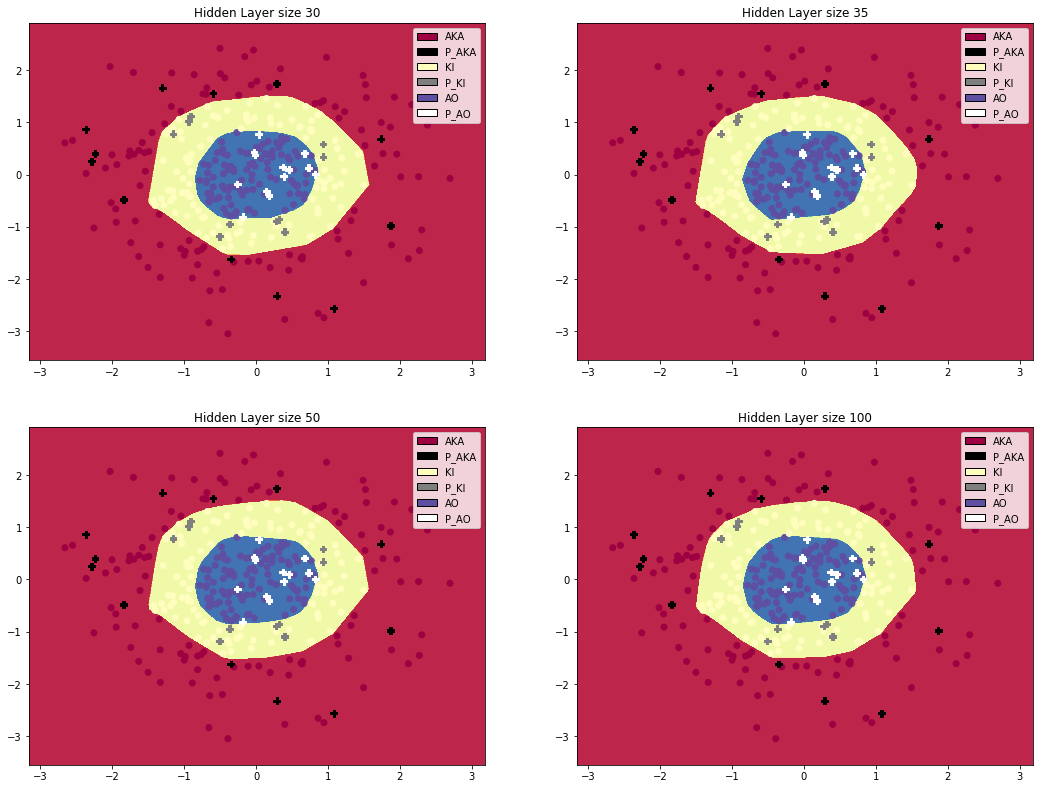

In [68]:
hidden_sizes= [30, 35, 50, 100]
plt.figure(figsize=(18, 36))

for i, hidden_size in enumerate(hidden_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % hidden_size)
    model = make_model(X_train, y_train, 50001, hidden_sizes[i], lr=0.002, print_loss=5000)
    predictions = predict(model, X_test)
    plot_decision_boundary(lambda x: predict(model, x), X_train, y_train)
    plt.scatter(X_test[:,0], X_test[:,1], s=45, c=predictions, cmap=plt.cm.binary, marker='P')
    show_legend()
plt.show()